In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os

# 定义文件路径
file_path = os.getenv('DATA_PATH', '.')
fire_data_file = os.path.join(file_path, 'california_fire_data.xlsx')
satellite_data_file = os.path.join(file_path, 'real_time_satellite_data.xlsx')

try:
    # 读取模拟数据文件（Excel格式）
    fire_data = pd.read_excel(fire_data_file)
    real_time_satellite_data = pd.read_excel(satellite_data_file)

    # 检查数据完整性
    required_columns = ['temperature', 'humidity', 'wind_speed', 'fuel_type', 'fire_risk']
    if not all(col in fire_data.columns for col in required_columns) or not all(col in real_time_satellite_data.columns for col in required_columns[:-1]):
        raise ValueError("数据集中缺少必要的列")

    # 对字符串特征进行编码
    label_encoder = LabelEncoder()
    label_encoder.fit(fire_data['fuel_type'])
    fire_data['fuel_type'] = label_encoder.transform(fire_data['fuel_type'])
    real_time_satellite_data['fuel_type'] = label_encoder.transform(real_time_satellite_data['fuel_type'])

    # 数据标准化
    scaler = StandardScaler()
    features = fire_data[['temperature', 'humidity', 'wind_speed']]
    features_scaled = scaler.fit_transform(features)

    real_time_features = real_time_satellite_data[['temperature', 'humidity', 'wind_speed']]
    real_time_features_scaled = scaler.transform(real_time_features)

except Exception as e:
    print(f"数据读取或处理失败: {e}")
    exit(1)

# 定义cWGAN模型
class Generator(nn.Module):
    def __init__(self, z_dim, condition_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim + condition_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, output_dim)

    def forward(self, z, condition):
        x = torch.cat([z, condition], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


class Critic(nn.Module):
    def __init__(self, input_dim, condition_dim):
        super(Critic, self).__init__()
        # 输入维度为input_dim + condition_dim
        self.fc1 = nn.Linear(input_dim + condition_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x, condition):
        x = torch.cat([x, condition], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


# 计算梯度惩罚
def compute_gradient_penalty(critic, real_samples, fake_samples, conditions, device):
    alpha = torch.rand((real_samples.size(0), 1)).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = critic(interpolates, conditions)
    fake = torch.ones(d_interpolates.size()).to(device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=False,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


# 训练cWGAN模型
def train_cWGAN(generator, critic, data_loader, n_epochs, device):
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.9))
    optimizer_C = torch.optim.Adam(critic.parameters(), lr=0.0002, betas=(0.5, 0.9))

    for epoch in range(n_epochs):
        for real_data, conditions in data_loader:  # 解包两个元素
            real_data = real_data.to(device)
            conditions = conditions.to(device)

            # Train Critic
            optimizer_C.zero_grad()
            z = torch.randn(real_data.size(0), 100).to(device)
            fake_data = generator(z, conditions).detach()
            real_validity = critic(real_data, conditions).mean()
            fake_validity = critic(fake_data, conditions).mean()
            gradient_penalty = compute_gradient_penalty(critic, real_data, fake_data, conditions, device)
            c_loss = fake_validity - real_validity + 10 * gradient_penalty
            optimizer_C.step()

            # Train Generator
            if epoch % 5 == 0:
                optimizer_G.zero_grad()
                z = torch.randn(real_data.size(0), 100).to(device)
                fake_data = generator(z, conditions)
                g_loss = -critic(fake_data, conditions).mean()
                g_loss.backward()  # 不需要 retain_graph=True
                optimizer_G.step()

        print(f"Epoch [{epoch}/{n_epochs}], C Loss: {c_loss.item()}, G Loss: {g_loss.item()}")


# 准备训练数据
features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
conditions_tensor = torch.tensor(fire_data['fuel_type'].values.reshape(-1, 1), dtype=torch.float32)
dataset = TensorDataset(features_tensor, conditions_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 初始化模型和设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(z_dim=100, condition_dim=1, output_dim=features_scaled.shape[1]).to(device)
critic = Critic(input_dim=features_scaled.shape[1], condition_dim=1).to(device)

# 训练模型
n_epochs = 100
train_cWGAN(generator, critic, data_loader, n_epochs, device)


Epoch [0/100], C Loss: 9.478425025939941, G Loss: -0.11995084583759308
Epoch [1/100], C Loss: 9.503693580627441, G Loss: -0.11995084583759308
Epoch [2/100], C Loss: 9.336575508117676, G Loss: -0.11995084583759308
Epoch [3/100], C Loss: 9.3557710647583, G Loss: -0.11995084583759308
Epoch [4/100], C Loss: 9.387086868286133, G Loss: -0.11995084583759308
Epoch [5/100], C Loss: 9.831506729125977, G Loss: -0.6616682410240173
Epoch [6/100], C Loss: 9.893453598022461, G Loss: -0.6616682410240173
Epoch [7/100], C Loss: 9.831218719482422, G Loss: -0.6616682410240173
Epoch [8/100], C Loss: 9.898697853088379, G Loss: -0.6616682410240173
Epoch [9/100], C Loss: 9.919944763183594, G Loss: -0.6616682410240173
Epoch [10/100], C Loss: 11.153748512268066, G Loss: -1.963647723197937
Epoch [11/100], C Loss: 11.319039344787598, G Loss: -1.963647723197937
Epoch [12/100], C Loss: 11.391927719116211, G Loss: -1.963647723197937
Epoch [13/100], C Loss: 11.289313316345215, G Loss: -1.963647723197937
Epoch [14/100

In [29]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import os

# 定义文件路径
file_path = os.getenv('DATA_PATH', '.')
fire_data_file = os.path.join(file_path, 'california_fire_data.xlsx')

try:
    # 读取模拟数据文件（Excel格式）
    fire_data = pd.read_excel(fire_data_file)

    # 检查数据完整性
    required_columns = ['temperature', 'humidity', 'wind_speed', 'fuel_type', 'fire_risk']
    if not all(col in fire_data.columns for col in required_columns):
        raise ValueError("数据集中缺少必要的列")

    # 对字符串特征进行编码
    label_encoder = LabelEncoder()
    label_encoder.fit(fire_data['fuel_type'])
    fire_data['fuel_type'] = label_encoder.transform(fire_data['fuel_type'])

    # 数据标准化
    scaler = StandardScaler()
    features = fire_data[['temperature', 'humidity', 'wind_speed']]
    features_scaled = scaler.fit_transform(features)

except Exception as e:
    print(f"数据读取或处理失败: {e}")
    exit(1)

# 定义cWGAN模型
class Generator(nn.Module):
    def __init__(self, z_dim, condition_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim + condition_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, output_dim)

    def forward(self, z, condition):
        x = torch.cat([z, condition], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


# 初始化模型和设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 100
condition_dim = 1
output_dim = features_scaled.shape[1]
generator = Generator(z_dim, condition_dim, output_dim).to(device)

# 加载生成器权重
generator.load_state_dict(torch.load('generator_model.pth'))
generator.eval()

# 生成新的数据
num_samples = 1000
z = torch.randn(num_samples, z_dim).to(device)
conditions = torch.tensor(fire_data['fuel_type'].values[:num_samples].reshape(-1, 1), dtype=torch.float32).to(device)
generated_data = generator(z, conditions).cpu().detach().numpy()

# 反标准化生成的数据
generated_data = scaler.inverse_transform(generated_data)

# 将生成的数据转换为DataFrame
generated_df = pd.DataFrame(generated_data, columns=['temperature', 'humidity', 'wind_speed'])

# 添加fuel_type列
generated_df['fuel_type'] = fire_data['fuel_type'].values[:num_samples]

# 打印生成的数据
print(generated_df.head())


   temperature   humidity  wind_speed  fuel_type
0    22.552422  22.596071   -2.099508          2
1    24.664064  12.503287   -4.573938          3
2    23.521240   8.002273   -7.483389          3
3     6.297889  45.944359   -5.177045          0
4    21.632532  22.503248   -2.347908          2


C:\Users\刘弗莫尔\AppData\Local\Temp\ipykernel_17320\3172151009.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator_model.pth'))

In [31]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import os

# 定义文件路径
file_path = os.getenv('DATA_PATH', '.')
fire_data_file = os.path.join(file_path, 'california_fire_data.xlsx')

try:
    # 读取模拟数据文件（Excel格式）
    fire_data = pd.read_excel(fire_data_file)

    # 检查数据完整性
    required_columns = ['temperature', 'humidity', 'wind_speed', 'fuel_type', 'fire_risk']
    if not all(col in fire_data.columns for col in required_columns):
        raise ValueError("数据集中缺少必要的列")

    # 对字符串特征进行编码
    label_encoder = LabelEncoder()
    label_encoder.fit(fire_data['fuel_type'])
    fire_data['fuel_type'] = label_encoder.transform(fire_data['fuel_type'])

    # 数据标准化
    scaler = StandardScaler()
    features = fire_data[['temperature', 'humidity', 'wind_speed']]
    features_scaled = scaler.fit_transform(features)

except Exception as e:
    print(f"数据读取或处理失败: {e}")
    exit(1)

# 定义cWGAN模型
class Generator(nn.Module):
    def __init__(self, z_dim, condition_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim + condition_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, output_dim)

    def forward(self, z, condition):
        x = torch.cat([z, condition], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


# 初始化模型和设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 100
condition_dim = 1
output_dim = features_scaled.shape[1]
generator = Generator(z_dim, condition_dim, output_dim).to(device)

# 加载生成器权重
generator.load_state_dict(torch.load('generator_model.pth'))
generator.eval()

# 生成新的数据
num_samples = 1000
z = torch.randn(num_samples, z_dim).to(device)
conditions = torch.tensor(fire_data['fuel_type'].values[:num_samples].reshape(-1, 1), dtype=torch.float32).to(device)
generated_data = generator(z, conditions).cpu().detach().numpy()

# 反标准化生成的数据
generated_data = scaler.inverse_transform(generated_data)

# 将生成的数据转换为DataFrame
generated_df = pd.DataFrame(generated_data, columns=['temperature', 'humidity', 'wind_speed'])

# 添加fuel_type列
generated_df['fuel_type'] = fire_data['fuel_type'].values[:num_samples]

# 打印生成的数据
print(generated_df.head())

# 定义火警阈值
# 假设我们定义一个简单的阈值规则来判断是否需要发出火警提示
# 例如，如果温度超过35度且湿度低于30%，则发出火警提示
temperature_threshold = 10
humidity_threshold = 30

# 生成火警提示
fire_alerts = generated_df[(generated_df['temperature'] > temperature_threshold) & (generated_df['humidity'] < humidity_threshold)]

# 打印火警提示
if not fire_alerts.empty:
    print("\n火警提示:")
    print(fire_alerts)
else:
    print("\n当前没有火警风险。")


   temperature   humidity  wind_speed  fuel_type
0    22.534290  21.647045   -2.404240          2
1    23.197573  12.014739   -5.510448          3
2    23.995598  14.566749   -4.561248          3
3     4.322707  44.557621   -7.065194          0
4    21.805525  21.101917   -3.829549          2

火警提示:
     temperature   humidity  wind_speed  fuel_type
0      22.534290  21.647045   -2.404240          2
1      23.197573  12.014739   -5.510448          3
2      23.995598  14.566749   -4.561248          3
4      21.805525  21.101917   -3.829549          2
5      13.978561  29.593962   -5.478698          1
..           ...        ...         ...        ...
993    21.969784  21.443151   -3.512708          2
994    21.204063  22.398603   -3.150569          2
997    23.222670  19.228947   -2.863203          2
998    23.944702  10.673953   -5.645908          3
999    23.059744  21.567049   -2.013365          2

[563 rows x 4 columns]


C:\Users\刘弗莫尔\AppData\Local\Temp\ipykernel_17320\2732654296.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator_model.pth'))

C:\Users\刘弗莫尔\AppData\Local\Temp\ipykernel_17320\1564807076.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('generator_model.pth'))

   temperature   humidity  wind_speed  fuel_type
0    22.637733  21.334352   -3.045466          2
1    24.096397  13.076007   -4.674187          3
2    23.868771  12.843421   -5.324460          3
3     8.319037  41.436909   -5.666687          0
4    23.653965  18.796841   -3.057907          2

火警提示:
     temperature   humidity  wind_speed  fuel_type
272    25.037930  12.710563   -4.478815          3
356    25.182037  13.675193   -4.105453          3
372    25.023451  10.212489   -5.362442          3
524    25.212738  12.887996   -4.297939          3
549    25.072548  11.994414   -4.799317          3
737    25.076967  11.402617   -5.289097          3


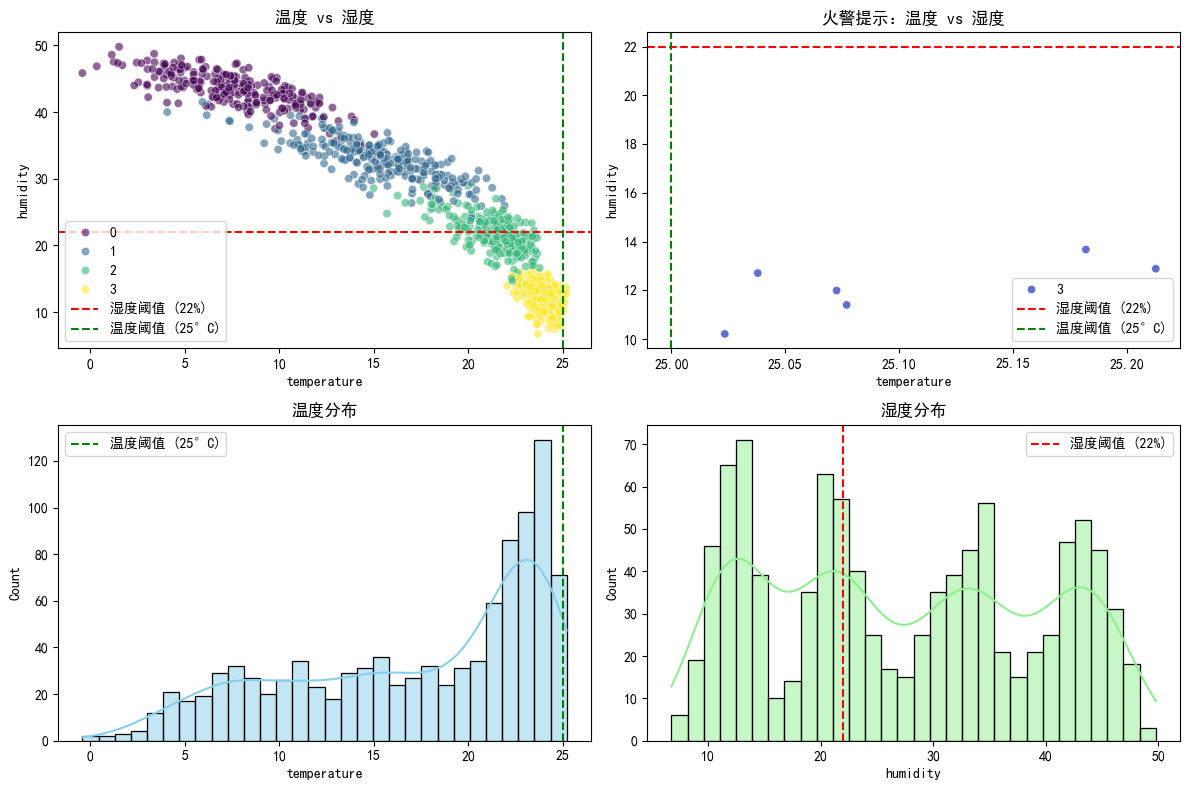

In [34]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 设置字体为SimHei
plt.rcParams['font.family'] = 'SimHei'

# 定义文件路径
file_path = os.getenv('DATA_PATH', '.')
fire_data_file = os.path.join(file_path, 'california_fire_data.xlsx')

try:
    # 读取模拟数据文件（Excel格式）
    fire_data = pd.read_excel(fire_data_file)

    # 检查数据完整性
    required_columns = ['temperature', 'humidity', 'wind_speed', 'fuel_type', 'fire_risk']
    if not all(col in fire_data.columns for col in required_columns):
        raise ValueError("数据集中缺少必要的列")

    # 对字符串特征进行编码
    label_encoder = LabelEncoder()
    label_encoder.fit(fire_data['fuel_type'])
    fire_data['fuel_type'] = label_encoder.transform(fire_data['fuel_type'])

    # 数据标准化
    scaler = StandardScaler()
    features = fire_data[['temperature', 'humidity', 'wind_speed']]
    features_scaled = scaler.fit_transform(features)

except Exception as e:
    print(f"数据读取或处理失败: {e}")
    exit(1)

# 定义cWGAN模型
class Generator(nn.Module):
    def __init__(self, z_dim, condition_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim + condition_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, output_dim)

    def forward(self, z, condition):
        x = torch.cat([z, condition], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


# 初始化模型和设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_dim = 100
condition_dim = 1
output_dim = features_scaled.shape[1]
generator = Generator(z_dim, condition_dim, output_dim).to(device)

# 加载生成器权重
generator.load_state_dict(torch.load('generator_model.pth'))
generator.eval()

# 生成新的数据
num_samples = 1000
z = torch.randn(num_samples, z_dim).to(device)
conditions = torch.tensor(fire_data['fuel_type'].values[:num_samples].reshape(-1, 1), dtype=torch.float32).to(device)
generated_data = generator(z, conditions).cpu().detach().numpy()

# 反标准化生成的数据
generated_data = scaler.inverse_transform(generated_data)

# 将生成的数据转换为DataFrame
generated_df = pd.DataFrame(generated_data, columns=['temperature', 'humidity', 'wind_speed'])

# 添加fuel_type列
generated_df['fuel_type'] = fire_data['fuel_type'].values[:num_samples]

# 打印生成的数据
print(generated_df.head())

# 定义火警阈值
# 假设我们定义一个简单的阈值规则来判断是否需要发出火警提示
# 例如，如果温度超过35度且湿度低于30%，则发出火警提示
temperature_threshold = 25
humidity_threshold = 22

# 生成火警提示
fire_alerts = generated_df[(generated_df['temperature'] > temperature_threshold) & (generated_df['humidity'] < humidity_threshold)]

# 打印火警提示
if not fire_alerts.empty:
    print("\n火警提示:")
    print(fire_alerts)
else:
    print("\n当前没有火警风险。")

# 数据可视化
plt.figure(figsize=(12, 8))

# 散点图：温度 vs 湿度
plt.subplot(2, 2, 1)
sns.scatterplot(data=generated_df, x='temperature', y='humidity', hue='fuel_type', palette='viridis', alpha=0.6)
plt.title('温度 vs 湿度')
plt.axhline(y=humidity_threshold, color='r', linestyle='--', label=f'湿度阈值 ({humidity_threshold}%)')
plt.axvline(x=temperature_threshold, color='g', linestyle='--', label=f'温度阈值 ({temperature_threshold}°C)')
plt.legend()

# 火警提示散点图：温度 vs 湿度
plt.subplot(2, 2, 2)
sns.scatterplot(data=fire_alerts, x='temperature', y='humidity', hue='fuel_type', palette='coolwarm', alpha=0.8)
plt.title('火警提示：温度 vs 湿度')
plt.axhline(y=humidity_threshold, color='r', linestyle='--', label=f'湿度阈值 ({humidity_threshold}%)')
plt.axvline(x=temperature_threshold, color='g', linestyle='--', label=f'温度阈值 ({temperature_threshold}°C)')
plt.legend()

# 温度分布直方图
plt.subplot(2, 2, 3)
sns.histplot(generated_df['temperature'], bins=30, kde=True, color='skyblue')
plt.title('温度分布')
plt.axvline(x=temperature_threshold, color='g', linestyle='--', label=f'温度阈值 ({temperature_threshold}°C)')
plt.legend()

# 湿度分布直方图
plt.subplot(2, 2, 4)
sns.histplot(generated_df['humidity'], bins=30, kde=True, color='lightgreen')
plt.title('湿度分布')
plt.axvline(x=humidity_threshold, color='r', linestyle='--', label=f'湿度阈值 ({humidity_threshold}%)')
plt.legend()

plt.tight_layout()
plt.show()
